<a href="https://colab.research.google.com/github/ozzmanmuhammad/Tweet-Classifier-Disaster-or-not/blob/main/Tweets_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweets Classification.

We'll be using RNN's architecture which are

1. LSTM
2. GRU
3. Bi-LSTM
4. Transferlearning using google's Universel Sentence Encoder pretrained model.

We'll also try some other architectures like for the experimentation like:

1. Naive Bayes
2. Feed-Forward NN
3. 1D Convolutional NN


In [1]:
# Geting helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-03-02 06:36:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-02 06:36:57 (54.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Text dataset
Kaggle dataset --> Introduction to NLP dataset (Tweets labeled as diaster or not diaster)

https://www.kaggle.com/c/nlp-getting-started/data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2022-03-02 06:37:04--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2022-03-02 06:37:04 (61.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing the text dataset

Multiple ways of visualizing the texts.


1.   Python Read
2.   Python Pandas
3.   tf load text



In [3]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# best practice is to suffle the datasets if they are not time related.. maybe this sample is already
# shuffled but we will do it again
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

balanced (60-40) binary dataset. if not we have to look at tensorflow imbalanced classification

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# lets visualize some random data from datasets
import random

random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(Real diaster)" if target > 0 else "(Not diaster)")
  print(f"Text:\n '{text}'\n")
  print(f"---\n")

Target: 0 (Not diaster)
Text:
 'Lately I been stressing make me wanna put a fuck nigga on a stretcher!'

---

Target: 0 (Not diaster)
Text:
 '@_PokemonCards_ @IceQueenFroslas why did they have to wreck it with ON SALE HERE ;-;'

---

Target: 1 (Real diaster)
Text:
 'Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/Calk5nv5Vc'

---

Target: 1 (Real diaster)
Text:
 '? 19th Day Since 17-Jul-2015 -- Nigeria: Suicide Bomb Attacks Killed 64 People; Blamed: Boko Haram [L.A. Times/AP] | http://t.co/O2cdKpSDfp'

---

Target: 0 (Not diaster)
Text:
 'well it feels like im on fire.'

---



### Split datasets into Taining and Validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1, # 10%
                                                                            random_state = 42)


In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

## Texts to Numbers


1.   Tokenization
2.   Embedding



In [14]:
# Text Vectorization (Tokenization)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [15]:
# these are the default parameter and values
text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = False)

Average of the lengths of the tweets

In [16]:
# Average number of token(word) in the training tweets
round(sum(len(i.split()) for i in train_sentences)/ len(train_sentences))

15

In [17]:
# Lets setup the Text vectorizer and its variables
max_vocab_length = 10000
max_length = 15 # from above

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [18]:
text_vectorizer.adapt(train_sentences)

In [19]:
# Lets Check what it id actually doing
sample_sentence = "There's going to rain tomarrow at night"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264, 104,   5, 314,   1,  17, 285,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# lets check it randomly on our training datasets

random_sentence = random.choice(train_sentences)
print(f"Original sentence: \n{random_sentence}\
        \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original sentence: 
R'lyeh by Upheaval http://t.co/829n4HJHOL        

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[9045,   18,  562,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Getting the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in Vocab {len(words_in_vocab)}")
print(f"most common words {top_5_words}")
print(f"least common words {bottom_5_words}")

Number of words in Vocab 10000
most common words ['', '[UNK]', 'the', 'a', 'in']
least common words ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Using an Embedding using Embedding layer

The parameter we care most about in this layer

1.   `input_dim` = The size of our vocabulary
2.   `output_dim` = The size of the output embedding vector.
3. `input_length` = length of the sequences being passed into the embedding layer



In [22]:
from tensorflow.keras import layers

In [23]:
embedding = layers.Embedding(input_dim= max_vocab_length,
                             output_dim = 128, # divisible by 8 GPU logic
                             input_length = max_length)

In [24]:
# Checking embedding with a random sample 
random_sentence = random.choice(train_sentences)
print(f"Original sentence:\n{random_sentence} \
        \n\n Embedded sentence:\n")

embed = embedding(text_vectorizer([random_sentence]))
embed

Original sentence:
Ashes 4th Test: 10 Hilarious Twitter Reactions to Australia's collapse http://t.co/6DznEjuVD3 by @Absolut_Sumya15         

 Embedded sentence:



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02286974,  0.01525793, -0.04618073, ..., -0.04977936,
          0.03953974, -0.03077583],
        [-0.04065794, -0.04349771, -0.01469184, ..., -0.03057897,
          0.04765922,  0.03828276],
        [ 0.03189177,  0.04478336, -0.01767046, ..., -0.02096021,
          0.01935098,  0.00703288],
        ...,
        [-0.03504543,  0.02816422, -0.01326675, ...,  0.01588949,
         -0.03535407, -0.04650671],
        [ 0.02104494, -0.00829742,  0.0341223 , ..., -0.00807982,
          0.01679761,  0.01582673],
        [ 0.02104494, -0.00829742,  0.0341223 , ..., -0.00807982,
          0.01679761,  0.01582673]]], dtype=float32)>

In [25]:
embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.02286974,  0.01525793, -0.04618073,  0.02820105,  0.0244418 ,
       -0.02726926, -0.015721  ,  0.01457426,  0.0367627 ,  0.01179594,
        0.04314691,  0.01501032, -0.04617393,  0.00826558,  0.048604  ,
       -0.00297406, -0.04110859, -0.00552875,  0.04718706,  0.03457573,
       -0.04223254,  0.00012449,  0.04710192,  0.04377088,  0.04794261,
        0.04830754, -0.03399936, -0.00779969, -0.03487056,  0.01699496,
        0.03735903, -0.04589052,  0.00634434,  0.03270369,  0.02423569,
       -0.03302896, -0.00126054, -0.04007586, -0.03748444,  0.04584148,
        0.00858597, -0.01796198,  0.01512677,  0.03665066, -0.03229269,
        0.04338281,  0.03369615,  0.01403857,  0.00786855, -0.04053879,
       -0.04887985, -0.03693765, -0.02838991,  0.04233593,  0.04587052,
        0.04311831,  0.01877568,  0.02879909, -0.01316733,  0.03145144,
       -0.0441887 , -0.01973555,  0.01174792,  0.00648748,  0.04710367,
       -0.018144

## Modelling a text dataset (Series of experiments)

Now we've got our data in numerical format, let's start building and comparing different models.

* Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

For each of these models, we're going to be following the TensorFlow steps in modelling:

* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Naive Bayes (baseline)

We'll use Sklearn Mutinominal Naive Bayes using the TF-IDF formula to convert our text to number

**NOTE:** It's common practice to use non-DL or traditional ML algorithm as baseline models because of their speed and then use DL to see if you can improve above them

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieve an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieve an accuracy of: 79.27%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
results = baseline_preds == val_labels
results[:10]

array([False, False,  True, False, False,  True,  True,  True,  True,
        True])

### Creating Evaluation Function 

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred)

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results = {"accuracy": model_accuracy,
                   "precision:": model_precision,
                   "recall:": model_recall,
                   "f1-score:": model_f1}

  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

### Model_1: feed forward neural network



In [ ]:
from helper_functions import create_tensorboard_callback

In [35]:
SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = tf.string, name = "Input_layer")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.GlobalAveragePooling1D(name = "AveragePooling1D_layer")(x) 

outputs = layers.Dense(1, activation="sigmoid", name = "Output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_Dense")


In [ ]:
model_1.summary()

Model: "model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 AveragePooling1D_layer (Glo  (None, 128)              0         
 balAveragePooling1D)                                            
                                                                 
 Output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
train_labels.shape, val_labels.shape

((6851,), (762,))

In [ ]:
model_1.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_1 = model_1.fit(x = train_sentences,
                        y = train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                 experiment_name = "Model_1_FeedForward")
                        ])

Saving TensorBoard log files to: model_logs/Model_1_FeedForward/20220113-095910
Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.6119 - accuracy: 0.6941 - val_loss: 0.5350 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4409 - accuracy: 0.8158 - val_loss: 0.4715 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3471 - accuracy: 0.8594 - val_loss: 0.4606 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2847 - accuracy: 0.8898 - val_loss: 0.4610 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2373 - accuracy: 0.9123 - val_loss: 0.4799 - val_accuracy: 0.7822


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.7822


[0.47985225915908813, 0.7821522355079651]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [ ]:
model_1_pred_probs[0]

array([0.35937178], dtype=float32)

In [ ]:
model_1_pred_probs[:10]

array([[0.35937178],
       [0.7424828 ],
       [0.99756104],
       [0.12607405],
       [0.12838906],
       [0.93537515],
       [0.9039668 ],
       [0.9936206 ],
       [0.96686053],
       [0.2687713 ]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format

model_1_pred = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_pred)
model_1_results

{'accuracy': 0.7821522309711286,
 'f1-score:': 0.7787825179570674,
 'precision:': 0.7877268665884849,
 'recall:': 0.7821522309711286}

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'f1-score:': 0.7862189758049549,
 'precision:': 0.8111390004213173,
 'recall:': 0.7926509186351706}

## Visualizing the learned Embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 AveragePooling1D_layer (Glo  (None, 128)              0         
 balAveragePooling1D)                                            
                                                                 
 Output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the learned weights matrix in the embedd layer (learned patterns in 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)
# this should be same as vocab size and embedding_dims (output_dim parameter)

(10000, 128)


In [ ]:
# lets visualize the weighted matrix and will use tensorflow tool: "Projector"
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Downloading it to PC so that we can upload it to projector tool
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks RNN's

### Model 2: LSTM
Long Short Term Memory (Most popular LSTM RNN Cells )

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.LSTM(units = 64)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name = "Model_2_LSTM")


In [ ]:
model_2.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
history_2 = model_2.fit(x = train_sentences,
                        y = train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                 experiment_name = "model_2_LSTM")
                        ])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220113-102732
Epoch 1/5
215/215 [==============================] - 9s 30ms/step - loss: 0.2226 - accuracy: 0.9196 - val_loss: 0.5742 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1568 - accuracy: 0.9404 - val_loss: 0.6299 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1255 - accuracy: 0.9518 - val_loss: 0.7909 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.1024 - accuracy: 0.9599 - val_loss: 0.8457 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0845 - accuracy: 0.9664 - val_loss: 0.9544 - val_accuracy: 0.7743


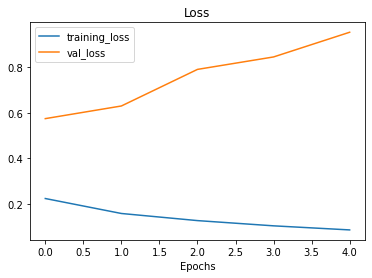

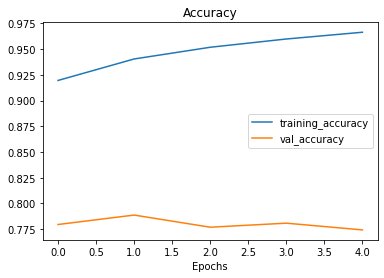

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(history_2)

**Model is Overfitting**

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:5]

array([[5.0489604e-03],
       [7.4950850e-01],
       [9.9983478e-01],
       [2.1313578e-02],
       [5.7613850e-04]], dtype=float32)

In [ ]:
model_2_pred = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(y_true = val_labels, y_pred = model_2_pred)
model_2_results

{'accuracy': 0.7742782152230971,
 'f1-score:': 0.7722311836526509,
 'precision:': 0.7759894665484696,
 'recall:': 0.7742782152230971}

In [ ]:
model_1_results

{'accuracy': 0.7821522309711286,
 'f1-score:': 0.7787825179570674,
 'precision:': 0.7877268665884849,
 'recall:': 0.7821522309711286}

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'f1-score:': 0.7862189758049549,
 'precision:': 0.8111390004213173,
 'recall:': 0.7926509186351706}

### Experiment to improve RNN LSTM (FAILED TO IMPROVE RESULTS)

As the model:2 was overfitting I tired to regularize the model.


In [ ]:
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.LSTM(64, activation="tanh", return_sequences=True)(x)
x = layers.LSTM(64)(x)

# x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_X = tf.keras.Model(inputs, outputs)


In [ ]:
model_X.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_X.fit(train_sentences, train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.1190 - accuracy: 0.9597 - val_loss: 0.8479 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0545 - accuracy: 0.9762 - val_loss: 1.3542 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0458 - accuracy: 0.9780 - val_loss: 1.3103 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0435 - accuracy: 0.9780 - val_loss: 1.4236 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0427 - accuracy: 0.9799 - val_loss: 1.4201 - val_accuracy: 0.7638


Model: "Model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

###Model: 3 GRU
GRU = Gated Recurret Unit
GRU cells have same features as LSTM but less parameters

In [ ]:
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.GRU(64)(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)


In [ ]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [ ]:
model_3.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
history_3 = model_3.fit(train_sentences, train_labels,
                        epochs = 5,
                        validation_data  = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(SAVE_DIR,
                                                                 "Model_3_GRU")
                        ])

Saving TensorBoard log files to: model_logs/Model_3_GRU/20220113-110015
Epoch 1/5
215/215 [==============================] - 8s 28ms/step - loss: 0.1341 - accuracy: 0.9470 - val_loss: 0.7659 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0587 - accuracy: 0.9774 - val_loss: 1.0153 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0474 - accuracy: 0.9785 - val_loss: 1.1340 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0406 - accuracy: 0.9796 - val_loss: 1.4579 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0393 - accuracy: 0.9807 - val_loss: 1.1452 - val_accuracy: 0.7730


**This Model is also overfitting the training data as you can see from the difference between loss and val_loss also from the accuracy and val_accuracy which is huge.**

In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:5]

array([[2.1300822e-02],
       [7.1174955e-01],
       [9.9994326e-01],
       [1.9527137e-01],
       [1.5473366e-04]], dtype=float32)

In [ ]:
model_3_pred = tf.squeeze(tf.round(model_3_pred_probs))
model_3_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(y_true = val_labels, y_pred = model_3_pred)
model_3_results

{'accuracy': 0.7729658792650919,
 'f1-score:': 0.77144803030122,
 'precision:': 0.77365375135567,
 'recall:': 0.7729658792650919}

### Model_4: Bidirectional RNN

In [ ]:
inputs = layers.Input(shape = (1,), dtype = "string")

x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.Bidirectional(layers.LSTM(64, return_sequences= True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs)

In [ ]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [ ]:
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_4 = model_4.fit(train_sentences, train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks=[
                                   create_tensorboard_callback(SAVE_DIR, "Model_4_Bidirectional")
                        ])

Saving TensorBoard log files to: model_logs/Model_4_Bidirectional/20220113-112415
Epoch 1/5
215/215 [==============================] - 13s 39ms/step - loss: 0.0978 - accuracy: 0.9676 - val_loss: 1.1141 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0438 - accuracy: 0.9785 - val_loss: 1.2625 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0383 - accuracy: 0.9806 - val_loss: 1.1926 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0370 - accuracy: 0.9813 - val_loss: 1.4133 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0367 - accuracy: 0.9823 - val_loss: 1.4592 - val_accuracy: 0.7690


**Same Pattern of Overfitting same as of other LSTM models**

In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:5]

array([[1.6056895e-03],
       [6.8894595e-01],
       [9.9999052e-01],
       [2.6214522e-01],
       [4.4582492e-05]], dtype=float32)

In [ ]:
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_pred)
model_4_results

{'accuracy': 0.7690288713910761,
 'f1-score:': 0.7671875324347506,
 'precision:': 0.7701356893081864,
 'recall:': 0.7690288713910761}

## Convolution Neural Network for texts

### Model_5: Conv1D 

In [ ]:
inputs = layers.Input(shape = (1,), dtype = "string" )
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Conv1D(filters=64,
                  kernel_size = 5,
                  strides = 1,
                  padding = "valid",
                  activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs)

In [ ]:
model_5.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
history_5 = model_5.fit(train_sentences, train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(SAVE_DIR,"Model_5_Conv1D")
                        ])

Saving TensorBoard log files to: model_logs/Model_5_Conv1D/20220113-121000
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1107 - accuracy: 0.9667 - val_loss: 0.9553 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0681 - accuracy: 0.9743 - val_loss: 1.1575 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0559 - accuracy: 0.9780 - val_loss: 1.2018 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0521 - accuracy: 0.9794 - val_loss: 1.1755 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0478 - accuracy: 0.9793 - val_loss: 1.2454 - val_accuracy: 0.7507


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

array([[5.6784302e-01],
       [6.9325835e-01],
       [9.9996972e-01],
       [5.3654641e-02],
       [3.2936878e-06]], dtype=float32)

In [ ]:
model_5_pred = tf.squeeze(tf.round(model_5_pred_probs))
model_5_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_5_results = calculate_results(val_labels, model_5_pred)
model_5_results

{'accuracy': 0.7506561679790026,
 'f1-score:': 0.7499080251314462,
 'precision:': 0.7502044394332691,
 'recall:': 0.7506561679790026}

## Model:6 Tensorflow Hub Pretrained Sentence Encoder

There are many models like BERT etc will use USE:
universal sentence encoder

In [28]:
import tensorflow_hub as hub

embedd = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embedd_sentence = embedd([sample_sentence])


In [29]:
embedd_sentence.shape

TensorShape([1, 512])

In [30]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [31]:
model_6 = tf.keras.Sequential([
          sentence_encoder_layer,
          layers.Dense(64, activation="relu"),
          layers.Dense(1, activation="sigmoid")                     
], name = "model_6_USE")

In [32]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [33]:
model_6.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [36]:
history_6 = model_6.fit(train_sentences, train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(SAVE_DIR, "Model_6_USE")
                        ])

Saving TensorBoard log files to: model_logs/Model_6_USE/20220302-063947
Epoch 1/5
215/215 [==============================] - 9s 21ms/step - loss: 0.5047 - accuracy: 0.7881 - val_loss: 0.4485 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4153 - accuracy: 0.8159 - val_loss: 0.4365 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4015 - accuracy: 0.8216 - val_loss: 0.4326 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3934 - accuracy: 0.8253 - val_loss: 0.4289 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3874 - accuracy: 0.8302 - val_loss: 0.4255 - val_accuracy: 0.8150


**First model from all above experiments that has less generalization error means not overfitting**

In [37]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17599688],
       [0.7694545 ],
       [0.98738134],
       [0.21084368],
       [0.7575342 ],
       [0.7572907 ],
       [0.9810894 ],
       [0.9792092 ],
       [0.9462439 ],
       [0.08732325]], dtype=float32)

In [38]:
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [39]:
model_6_results = calculate_results(val_labels, model_6_pred)
model_6_results

{'accuracy': 0.8149606299212598,
 'f1-score:': 0.8139016283708382,
 'precision:': 0.8159654539826816,
 'recall:': 0.8149606299212598}

In [ ]:
baseline_results

### Experiment:2 IMPROVED THE MODEL BY ADDING TRAINABLE LAYER

In [ ]:
model_X1 = tf.keras.Sequential([
          sentence_encoder_layer,
          layers.Dense(64, activation="relu"),
          layers.Dense(1, activation="sigmoid")                     
], name = "model_6_USE")



In [ ]:
model_X1.summary()

In [ ]:
model_X1.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_X1 = model_X1.fit(train_sentences, train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(SAVE_DIR, "Model_6_USE")
                        ])

Saving TensorBoard log files to: model_logs/Model_6_USE/20220113-132211
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.3503 - accuracy: 0.8460 - val_loss: 0.4260 - val_accuracy: 0.8202
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3424 - accuracy: 0.8483 - val_loss: 0.4303 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3360 - accuracy: 0.8529 - val_loss: 0.4310 - val_accuracy: 0.8202
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3291 - accuracy: 0.8580 - val_loss: 0.4350 - val_accuracy: 0.8241
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3211 - accuracy: 0.8616 - val_loss: 0.4320 - val_accuracy: 0.8215


**Improved slightly that is 1% by adding dense trainable layer.**

## Model_7: Pretrained USE but 10% train data

In [ ]:
# # subset of training data
# # THIS SPLIT LEAD TO DATA LEAKAGE THATS WHY MODEL 7 WAS PERFOMING BETTER ONLY ON 10%
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac = 0.1, random_state = 42)
# train_data_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_data_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Spliting data rightway
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# train_10_percent["target"].value_counts()

In [ ]:
# model_7 = tf.keras.models.clone_model(model_X1) # samething

model_7 = tf.keras.Sequential([
          sentence_encoder_layer,
          layers.Dense(64, activation = "relu"),
          layers.Dense(1, activation="sigmoid")                     
], name = "Model_7_10Percent")

model_7.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_7.summary()

Model: "Model_7_10Percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_26 (Dense)            (None, 64)                32832     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_7 = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [
                                     create_tensorboard_callback(SAVE_DIR, "Model_7_USE_10Percent_FIXED")
                        ])

Saving TensorBoard log files to: model_logs/Model_7_USE_10Percent_FIXED/20220113-140924
Epoch 1/5
22/22 [==============================] - 2s 44ms/step - loss: 0.6696 - accuracy: 0.6453 - val_loss: 0.6485 - val_accuracy: 0.7034
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6008 - accuracy: 0.7971 - val_loss: 0.5938 - val_accuracy: 0.7638
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5271 - accuracy: 0.8204 - val_loss: 0.5380 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4654 - accuracy: 0.8277 - val_loss: 0.5051 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4224 - accuracy: 0.8350 - val_loss: 0.4893 - val_accuracy: 0.7795


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred = tf.squeeze(tf.round(model_7_pred_probs))
model_7_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [ ]:
model_7_results = calculate_results(val_labels, model_7_pred)
model_7_results

{'accuracy': 0.7795275590551181,
 'f1-score:': 0.7783167829714759,
 'precision:': 0.7799065773530309,
 'recall:': 0.7795275590551181}

##Comparing Model Results

In [ ]:
all_model_results = pd.DataFrame({"Baseline": baseline_results,
                                  "Model 1: FFN":  model_1_results,
                                  "Model 2: LSTM":  model_2_results,
                                  "Model 3: GRU":  model_3_results,
                                  "Model 4: Bidir":  model_4_results,
                                  "Model 5: Conv1D":  model_5_results,
                                  "Model 6: USE" :  model_6_results,
                                  "model 7: USE 10%":  model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision:,recall:,f1-score:
Baseline,0.792651,0.811139,0.792651,0.786219
Model 1: FFN,0.782152,0.787727,0.782152,0.778783
Model 2: LSTM,0.774278,0.775989,0.774278,0.772231
Model 3: GRU,0.772966,0.773654,0.772966,0.771448
Model 4: Bidir,0.769029,0.770136,0.769029,0.767188
Model 5: Conv1D,0.750656,0.750204,0.750656,0.749908
Model 6: USE,0.813648,0.816389,0.813648,0.811958
model 7: USE 10%,0.779528,0.779907,0.779528,0.778317


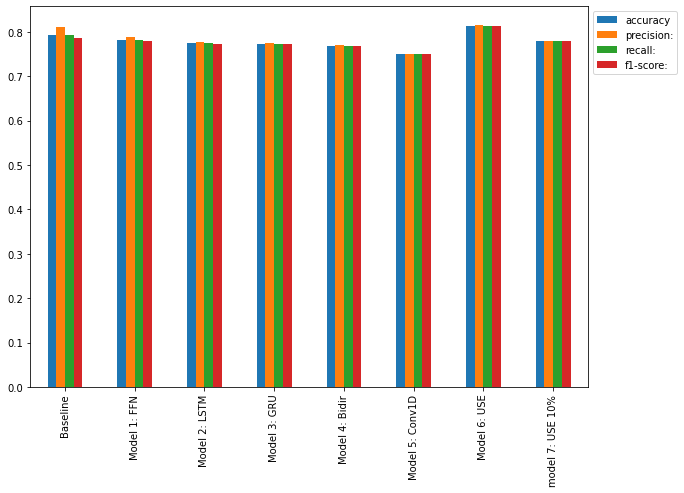

In [ ]:
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

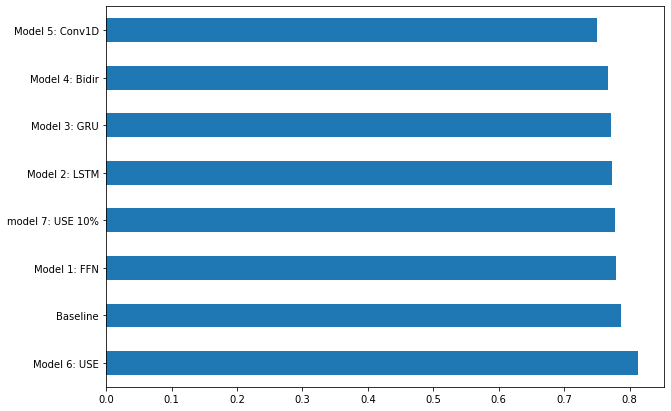

In [ ]:
all_model_results.sort_values("f1-score:", ascending=False)["f1-score:"].plot(kind = "barh", figsize = (10,7));

## Finding the most wrong predictions

AKA: "Model drivion data exploration" or "Active learning"

In [ ]:
model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 0.4286 - accuracy: 0.8136


[0.4286438226699829, 0.8136482834815979]

In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
len(model_6_pred)

762

In [ ]:
val_df = pd.DataFrame({"Text": val_sentences,
                       "Labels": val_labels,
                       "preds":model_6_pred,
                       "pred_probs":tf.squeeze(model_6_pred_probs)})
val_df.head()

,Text,Labels,preds,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.179577
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.792061
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988335
3,@camilacabello97 Internally and externally scr...,1,0.0,0.205663
4,Radiation emergency #preparedness starts with ...,1,1.0,0.754399


In [ ]:
most_wrong = val_df[val_df["Labels"] != val_df["preds"]].sort_values("pred_probs", ascending = False)
most_wrong[:10]

,Text,Labels,preds,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.933197
759,FedEx will no longer transport bioterror patho...,0,1.0,0.900651
628,@noah_anyname That's where the concentration c...,0,1.0,0.874034
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.857941
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.841301
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.838953
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.832573
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.808906
144,The Sound of Arson,0,1.0,0.796575
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.792061


## Predicting on unseen Tweets

In [41]:
# Ftn for predicting
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [43]:
tweet_1 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"
tweet_2 = "This mobile App may help these people to predict this powerfull M7.9 earthquake "
tweet_3 = "Love the explosion effects in the new spiderman movie"

In [44]:
# Make a prediction on Tweets
predict_on_sentence(model=model_6, # use the USE model
                    sentence=tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9760690927505493
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


In [45]:
predict_on_sentence(model=model_6,
                    sentence=tweet_2)

Pred: 1.0 (real disaster) Prob: 0.6940425634384155
Text:
This mobile App may help these people to predict this powerfull M7.9 earthquake 


In [46]:
predict_on_sentence(model=model_6,
                    sentence=tweet_3)

Pred: 0.0 (not real disaster) Prob: 0.222028449177742
Text:
Love the explosion effects in the new spiderman movie


##Analysis

Model_6 can clearly classifiy the tweets, tweet_3 was somewhat tricky but it classified it correct. Futher experiments can be done to improve our RNN models to imporve the overfitting and accuracy.